In [1]:
from OASIS import OASISConfig, train, evaluate, view_and_process
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import os
from OASIS.utils import ensure_bchw, invert_scale_log10p_torch

In [2]:
cfg = OASISConfig()

In [3]:
cfg

OASISConfig(data_root='../data/tensors', kinds=('hybrid', 'NR'), split='train', hw=(288, 512), file_pattern='*.pt', dataframe_root='../data/dataframes', base_channels=32, model_dir='../data/models', best_training_weights='best.pt', last_training_weights='last.pt', epochs=50, batch_size=16, lr=0.0002, patience=10, seed=42, device='cuda', n_train_per_kind=18000, n_val_per_kind=2000, w_ER=5.0, w_NR=1.0, W_ER=3.0, W_NR=1.0, W_overlap=6.0, alpha_reg=1.0, alpha_tv=0.01, model_file='../data/models/nominal_weights.pt', eval_split='test', eval_batch_size=16)

In [5]:
### Run this cell only once
### The cell creates test-set tensors for evaluation

!python generate_tensors.py

Generating 2086 hybrid tensors to ../data/tensors/test/hybrid
  0%|                                                  | 0/2086 [00:00<?, ?it/s]/home/jeef/OASIS/OASIS/generate_tensors.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "valid":  torch.tensor(valid, dtype=torch.float32),                     # [H,W]
100%|██████████████████████████████████████| 2086/2086 [00:18<00:00, 112.70it/s]
Wrote 2086 tensors to ../data/tensors/test/hybrid
Generating 2086 NR tensors to ../data/tensors/test/NR
  0%|                                                  | 0/2086 [00:00<?, ?it/s]/home/jeef/OASIS/OASIS/generate_tensors.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "valid":  torch.tensor(

In [4]:
a = torch.load('../data/tensors/test/hybrid/10.pt')

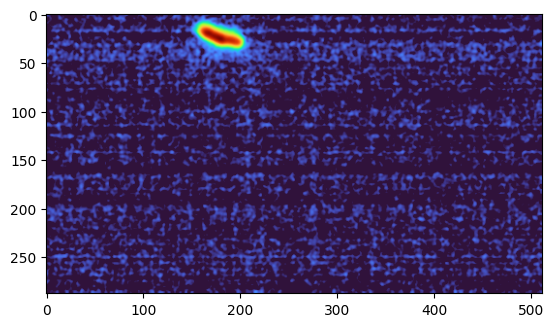

In [6]:
plt.imshow(a['target'][1],cmap='turbo')

In [ ]:
# Train
"""No training data is included here
but if you have training data you can
of course call train() as shown below
to train a model"""
#model = train(cfg)

In [7]:
hybrid_df = pd.read_pickle(os.path.join(cfg.dataframe_root,'hybrid.pkl'))
NR_df = pd.read_pickle(os.path.join(cfg.dataframe_root,'NR.pkl'))
dfs = {'NR':NR_df,'hybrid':hybrid_df}

In [8]:
# Evaluate on both the hybrid and NR-only sets
models = {}
datasets = {}
for species in dfs.keys():
    models[species], datasets[species], metrics = evaluate(cfg, species=species)

/home/jeff/anaconda3/envs/OASIS_test/lib/python3.10/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[EVAL] loss:0.0016 | reg:0.0013 | tv:0.0286
[EVAL] loss:0.0150 | reg:0.0148 | tv:0.0234


In [9]:
I_pred= {}
I_truth = {}
diff = {}
I_pred_NR = {}
I_truth_NR = {}
diff_NR = {}
for key in models.keys():
    species = key.split('_')[0]
    #ER track
    I_pred[key] = []
    I_truth[key] = []
    diff[key] = []

    #NR_track
    I_pred_NR[key] = []
    I_truth_NR[key] = []
    diff_NR[key] = []

    for i in tqdm(range(0,len(dfs[species]))):
        Ip,It,d,IpNR,ItNR,dNR = view_and_process(
                models[key],
                datasets[key],
                idx=i,                  # change index to browse
                invert=True,            # set True if ds_val is 'test' and you want raw-domain plots
                mask = True,
                plot = False,
            return_NR = True
            )
        I_pred[key].append(Ip)
        I_truth[key].append(It)
        if species == 'hybrid':
            diff[key].append(d)
        I_pred_NR[key].append(IpNR)
        I_truth_NR[key].append(ItNR)
        diff_NR[key].append(dNR)

  0%|                                                                        | 0/500 [00:00<?, ?it/s]/home/jeff/workspace/OASIS_test/OASIS/OASIS/eval.py:114: RuntimeWarning: divide by zero encountered in scalar divide
  ERrel = (ERp-ERt)/ERt*100.0
  8%|█████                                                          | 40/500 [00:14<02:48,  2.72it/s]/home/jeff/workspace/OASIS_test/OASIS/OASIS/eval.py:114: RuntimeWarning: invalid value encountered in scalar divide
  ERrel = (ERp-ERt)/ERt*100.0
/home/jeff/workspace/OASIS_test/OASIS/OASIS/eval.py:115: RuntimeWarning: invalid value encountered in scalar divide
  NRrel = (NRp-NRt)/NRt*100.0
100%|██████████████████████████████████████████████████████████████| 500/500 [02:56<00:00,  2.83it/s]


In [10]:
for key in dfs.keys():
    dfs[key]['NR_pred_intensity'] = I_pred_NR[key]
    dfs[key]['NR_truth_intensity'] = I_truth_NR[key]
    dfs[key]['NR_percent_diff'] = diff_NR[key]
    dfs[key]['ER_pred_intensity'] = I_pred[key]
    if key == 'hybrid': #Below are only relevant for hybrids
        dfs[key]['ER_truth_intensity'] = I_truth[key]
        dfs[key]['ER_percent_diff'] = diff[key]

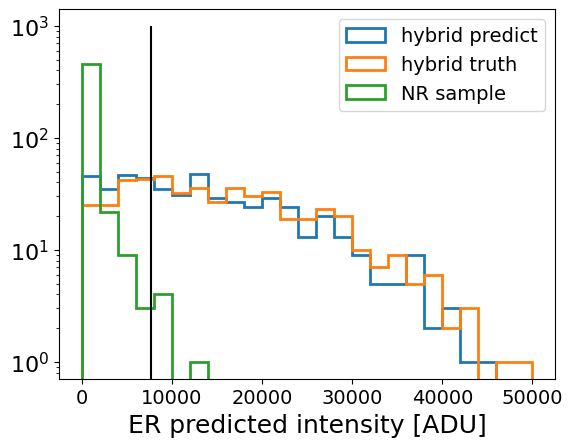

In [83]:
plt.hist(dfs['hybrid']['ER_pred_intensity'],bins=25,range=(0,50000),
         histtype='step',label='hybrid predict',lw=2)
plt.hist(dfs['hybrid']['ER_truth_intensity'],bins=25,range=(0,50000),
         histtype='step',label='hybrid truth',lw=2)
plt.hist(dfs['NR']['ER_pred_intensity'],bins=25,range=(0,50000),
         histtype='step',label='NR sample',lw=2)
plt.vlines(dfs['hybrid'].query('3.6 <= ER_truth_energy <= 4.4')['ER_truth_intensity'].mean(),0,1000,color='k') #4 keV threshold line
plt.xlabel('ER predicted intensity [ADU]')
plt.yscale('log')
plt.legend()

In [91]:
#Print fraction of NR-only data where at least 4 keV of visible energy was reconstructed
thresh = dfs['hybrid'].query('3.6 <= ER_truth_energy <= 4.4')['ER_truth_intensity'].mean()
print(f"NR-only false positive percentage: {len(dfs['NR'].loc[dfs['NR']['ER_pred_intensity']>thresh])/len(dfs['NR'])*100} pct.")

NR-only false positive percentage: 1.2 pct.


### Let's look at ER intensity reconstruction errors

In [14]:
#We'll consider 4-15 keV
bins = np.linspace(4,15,12)
bins[0] = 3.999

Text(0.5, 0, 'ER Intensity error [%]')

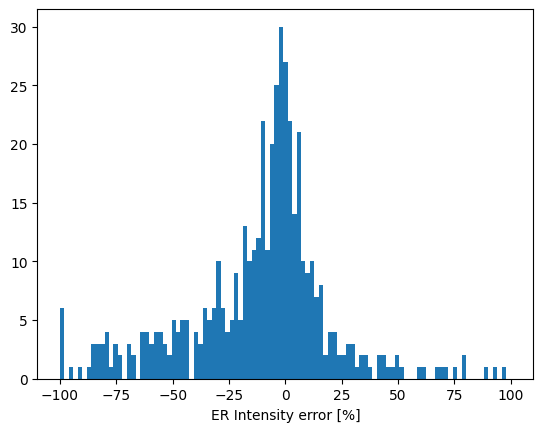

In [16]:
plt.hist(dfs['hybrid']['ER_percent_diff'],bins=101,range=(-100,100));
plt.xlabel('ER Intensity error [%]')

In [17]:
dfs['hybrid']['ER_percent_diff'].median()

-4.96741496026516

In [18]:
#Compute median and IQR of ER track intensity error binned by keV energy steps 
meds = dfs['hybrid'].query('4<= ER_truth_energy <= 15 & ER_truth_intensity>0').groupby(pd.cut(dfs['hybrid'].query('4<= ER_truth_energy <= 15 & ER_truth_intensity>0')['ER_truth_energy'],bins = bins))['ER_percent_diff'].median()
eups = dfs['hybrid'].query('4<= ER_truth_energy <= 15 & ER_truth_intensity>0').groupby(pd.cut(dfs['hybrid'].query('4<= ER_truth_energy <= 15 & ER_truth_intensity>0')['ER_truth_energy'],bins = bins))['ER_percent_diff'].apply(lambda x: np.quantile(x,0.75))
elows = dfs['hybrid'].query('4<= ER_truth_energy <= 15 & ER_truth_intensity>0').groupby(pd.cut(dfs['hybrid'].query('4<= ER_truth_energy <= 15 & ER_truth_intensity>0')['ER_truth_energy'],bins = bins))['ER_percent_diff'].apply(lambda x: np.quantile(x,0.25))

/tmp/ipykernel_47812/80200198.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  meds = dfs['hybrid'].query('4<= ER_truth_energy <= 15 & ER_truth_intensity>0').groupby(pd.cut(dfs['hybrid'].query('4<= ER_truth_energy <= 15 & ER_truth_intensity>0')['ER_truth_energy'],bins = bins))['ER_percent_diff'].median()
/tmp/ipykernel_47812/80200198.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eups = dfs['hybrid'].query('4<= ER_truth_energy <= 15 & ER_truth_intensity>0').groupby(pd.cut(dfs['hybrid'].query('4<= ER_truth_energy <= 15 & ER_truth_intensity>0')['ER_truth_energy'],bins = bins))['ER_percent_diff'].apply(l

/tmp/ipykernel_47812/4174194055.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


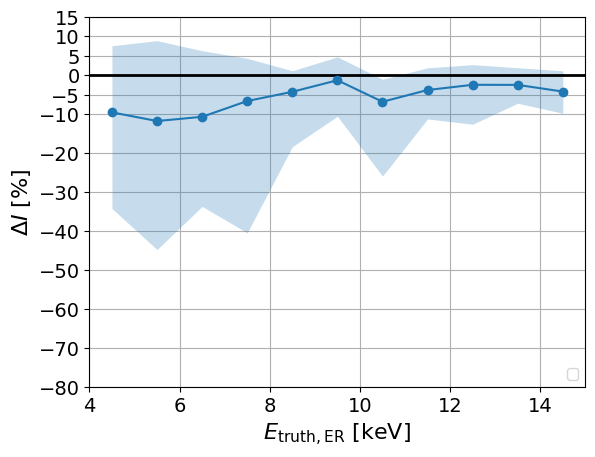

In [19]:
plt.rc('legend', fontsize=10)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=16)
plt.rc('axes', titlesize=16)

centers = (bins[:-1] + bins[1:]) / 2

# main line (median)
line, = plt.plot(centers, meds, 'o-', lw=1.5, zorder=3)
color = line.get_color()

# shaded error band (asymmetric)
plt.fill_between(centers, elows, eups, color=color, alpha=0.25, linewidth=0, zorder=2)

# axes styling (unchanged)
plt.ylabel(r'$\Delta I$ [%]')
plt.xlabel(r'$E_\mathrm{truth,ER}$ [keV]')
plt.yticks([-80,-70,-60,-50,-40,-30,-20,-10,-5,0,5,10,15])
plt.grid()
plt.hlines(0, 4, 15, color='k', lw=2)
plt.xlim(4, 15)
plt.ylim(-80, 15)
plt.legend(loc='lower right')

In [103]:
def visualize(df, model, dataset, idx=0, mask = True,plot_NR = False, key = None):
    """
    Visualize a single sample: input, preds, targets, residuals.
    - invert=True uses (s,ymax10) from dataset (requires split='test') to invert log10p.
    """
    device = ("cuda" if torch.cuda.is_available() else "cpu")

    sample = dataset[idx]
    tmp = df.iloc[idx]

    I_in, t, valid, aux = sample
    s = torch.tensor(aux.get("s", 1.0)).view(1,1,1,1)
    ymax10 = torch.tensor(aux.get("ymax10", 1.0)).view(1,1,1,1)

    # to device / shapes
    I_in   = ensure_bchw(I_in.float().to(device))    # [1,1,H,W]
    t      = ensure_bchw(t.float().to(device))       # [1,2,H,W]
    valid  = ensure_bchw(valid.float().to(device))   # [1,1,H,W]
    s      = s.to(device).type_as(I_in)
    ymax10 = ymax10.to(device).type_as(I_in)

    model.eval()
    I_hat = model(I_in)                               # [1,2,H,W]

    # Choose view domain
    # invert both prediction and target to raw domain
    # split channels
    I_hat_ER = I_hat[:,0:1]
    I_hat_NR = I_hat[:,1:2]
    t_ER     = t[:,0:1]
    t_NR     = t[:,1:2]

    I_in_raw     = invert_scale_log10p_torch(I_in, s, ymax10)
    I_hat_ER_raw = invert_scale_log10p_torch(I_hat_ER, s, ymax10)
    I_hat_NR_raw = invert_scale_log10p_torch(I_hat_NR, s, ymax10)
    t_ER_raw     = invert_scale_log10p_torch(t_ER,     s, ymax10)
    t_NR_raw     = invert_scale_log10p_torch(t_NR,     s, ymax10)

    if mask:
        I_hat_ER_raw = I_hat_ER_raw*valid
        I_hat_NR_raw = I_hat_NR_raw*valid

    to_show = {
        "Input (scaled)": I_in_raw[0,0].cpu().detach(),
        "Pred ER (raw)": I_hat_ER_raw[0,0].cpu().detach(),
        "GT ER (raw)": t_ER_raw[0,0].cpu().detach(),
        "Pred NR (raw)": I_hat_NR_raw[0,0].cpu().detach(),
        "GT NR (raw)": t_NR_raw[0,0].cpu().detach(),
        "Residual ER (raw)": (I_hat_ER_raw - t_ER_raw)[0,0].cpu().detach().abs(),
        "Residual NR (raw)": (I_hat_NR_raw - t_NR_raw)[0,0].cpu().detach().abs(),
    }
    if key is None:
        try:
            print("Intensity percent diff (pred - truth) = %s, Epred = %s, Etruth = %s"%(
                                                    np.round((I_hat_ER_raw[0,0].cpu().detach().numpy().sum()-t_ER_raw[0,0].cpu().detach().numpy().sum())/t_ER_raw[0,0].cpu().detach().numpy().sum()*100),
                                                            tmp['ER_pred_intensity']/tmp['ER_truth_intensity']*tmp['ER_truth_energy'],tmp['ER_truth_energy']))
        except:
            print("ER est. energy [keV]: %s"%(tmp['ER_pred_intensity']*4/thresh))
    else:
        prefix = key.split('_')[0]
        suffix = key[len(prefix)+1:]
        try:
            print("Intensity percent diff (pred - truth) = %s, Epred = %s, Etruth = %s"%(
                                                    np.round((I_hat_ER_raw[0,0].cpu().detach().numpy().sum()-t_ER_raw[0,0].cpu().detach().numpy().sum())/t_ER_raw[0,0].cpu().detach().numpy().sum()*100),
                                                            tmp['ER_pred_intensity_%s'%(suffix)]/tmp['ER_truth_intensity_%s'%(suffix)]*tmp['ER_truth_energy'],tmp['ER_truth_energy']))
        except:
            print("ER est. energy [keV]: %s"%(tmp['ER_pred_intensity_%s'%(suffix)]*4/thresh))
    if plot_NR:
        plt.figure(figsize=(18, 9))
        plt.subplot(2,3,1)
        im = plt.imshow(np.log10(I_in[0,0].cpu().detach()+1),cmap='jet')
        plt.colorbar(im,orientation='horizontal')
        plt.title('Hybrid (log scaled)')
        try:
            plt.xlim(tmp['col'].min(),tmp['col'].max()+1)
            plt.ylim(tmp['row'].min(),tmp['row'].max()+1)
        except:
            plt.xlim(tmp['colmin'],tmp['colmax']+1)
            plt.ylim(tmp['rowmin'],tmp['rowmax']+1)

        plt.subplot(2,3,3)
        im = plt.imshow(I_hat_NR_raw[0,0].cpu().detach(),cmap='jet',vmax=max(I_hat_NR_raw[0,0].cpu().detach().numpy().max(),
                                                               t_NR_raw[0,0].cpu().detach().numpy().max()))
        plt.colorbar(im,orientation='horizontal')
        plt.title("Predicted NR")
        try:
            plt.xlim(tmp['col'].min(),tmp['col'].max()+1)
            plt.ylim(tmp['row'].min(),tmp['row'].max()+1)
        except:
            plt.xlim(tmp['colmin'],tmp['colmax']+1)
            plt.ylim(tmp['rowmin'],tmp['rowmax']+1)

        plt.subplot(2,3,6)
        im = plt.imshow(t_NR_raw[0,0].cpu().detach(),cmap='jet',vmax=max(I_hat_NR_raw[0,0].cpu().detach().numpy().max(),
                                                               t_NR_raw[0,0].cpu().detach().numpy().max()))
        plt.colorbar(im,orientation='horizontal')
        plt.title("Truth NR")
        try:
            plt.xlim(tmp['col'].min(),tmp['col'].max()+1)
            plt.ylim(tmp['row'].min(),tmp['row'].max()+1)
        except:
            plt.xlim(tmp['colmin'],tmp['colmax']+1)
            plt.ylim(tmp['rowmin'],tmp['rowmax']+1)


        plt.subplot(2,3,2)
        im = plt.imshow(I_hat_ER_raw[0,0].cpu().detach(),cmap='jet',vmax=max(I_hat_ER_raw[0,0].cpu().detach().numpy().max(),
                                                               t_ER_raw[0,0].cpu().detach().numpy().max()))
        plt.colorbar(im,orientation='horizontal')
        plt.title("Predicted ER")
        try:
            plt.xlim(tmp['col'].min(),tmp['col'].max()+1)
            plt.ylim(tmp['row'].min(),tmp['row'].max()+1)
        except:
            plt.xlim(tmp['colmin'],tmp['colmax']+1)
            plt.ylim(tmp['rowmin'],tmp['rowmax']+1)

        plt.subplot(2,3,5)
        im = plt.imshow(t_ER_raw[0,0].cpu().detach(),cmap='jet',vmax=max(I_hat_ER_raw[0,0].cpu().detach().numpy().max(),
                                                               t_ER_raw[0,0].cpu().detach().numpy().max()))
        plt.colorbar(im,orientation='horizontal')
        plt.title("Truth ER")
        try:
            plt.xlim(tmp['col'].min(),tmp['col'].max()+1)
            plt.ylim(tmp['row'].min(),tmp['row'].max()+1)
        except:
            plt.xlim(tmp['colmin'],tmp['colmax']+1)
            plt.ylim(tmp['rowmin'],tmp['rowmax']+1)

        plt.subplot(2,3,4)
        im = plt.imshow((I_hat_ER_raw - t_ER_raw)[0,0].cpu().detach().abs(),cmap='jet',vmax=max(I_hat_ER_raw[0,0].cpu().detach().numpy().max(),
                                                               t_ER_raw[0,0].cpu().detach().numpy().max()))
        plt.colorbar(im,orientation='horizontal')
        plt.title('ER absolute residual')
        try:
            plt.xlim(tmp['col'].min(),tmp['col'].max()+1)
            plt.ylim(tmp['row'].min(),tmp['row'].max()+1)
        except:
            plt.xlim(tmp['colmin'],tmp['colmax']+1)
            plt.ylim(tmp['rowmin'],tmp['rowmax']+1)
    else:
        plt.figure(figsize=(8, 6))
        plt.subplot(2,2,1)
        im = plt.imshow(I_in[0,0].cpu().detach(),cmap='jet')
        plt.colorbar(im,orientation='horizontal',shrink=1,pad=0).set_label('Log-Norm Intensity [a.u.]',labelpad=0)
        plt.title('Input (log scaled)',size=16)
        try:
            plt.xlim(tmp['col'].min(),tmp['col'].max()+1)
            plt.ylim(tmp['row'].min(),tmp['row'].max()+1)
        except:
            try:
                plt.xlim(tmp['colmin'],tmp['colmax']+1)
                plt.ylim(tmp['rowmin'],tmp['rowmax']+1)
            except:
                colmin = min(tmp['ER_colmin'],tmp['NR_colmin'])
                rowmin = min(tmp['ER_rowmin'],tmp['NR_rowmin'])
                colmax = max(tmp['ER_colmax'],tmp['NR_colmax'])
                rowmax = max(tmp['ER_rowmax'],tmp['NR_rowmax'])
                plt.xlim(colmin,colmax+1)
                plt.ylim(rowmin,rowmax+1)        
        #plt.hlines(60,410-31.25,410,color='white')
        #plt.text(386,62,"5mm",color='w',size=16)
        plt.xticks([])
        plt.yticks([])

        plt.subplot(2,2,2)
        im = plt.imshow(I_hat_ER_raw[0,0].cpu().detach(),cmap='jet',vmax=max(I_hat_ER_raw[0,0].cpu().detach().numpy().max(),
                                                               t_ER_raw[0,0].cpu().detach().numpy().max()))
        #im = plt.imshow(I_hat_ER_raw[0,0].cpu().detach(),cmap='jet',vmax=50)
        plt.colorbar(im,orientation='horizontal',shrink=1,pad=0).set_label('Intensity [ADU]',labelpad=0)
        plt.title("Predicted ER",size=16)
        try:
            plt.xlim(tmp['col'].min(),tmp['col'].max()+1)
            plt.ylim(tmp['row'].min(),tmp['row'].max()+1)
        except:
            try:
                plt.xlim(tmp['colmin'],tmp['colmax']+1)
                plt.ylim(tmp['rowmin'],tmp['rowmax']+1)
            except:
                colmin = min(tmp['ER_colmin'],tmp['NR_colmin'])
                rowmin = min(tmp['ER_rowmin'],tmp['NR_rowmin'])
                colmax = max(tmp['ER_colmax'],tmp['NR_colmax'])
                rowmax = max(tmp['ER_rowmax'],tmp['NR_rowmax'])
                plt.xlim(colmin,colmax+1)
                plt.ylim(rowmin,rowmax+1)                
        #plt.hlines(28,410-31.25,410,color='white')
        #plt.text(386,30,"5mm",color='w',size=16)
        plt.xticks([])
        plt.yticks([])

        plt.subplot(2,2,4)
        im = plt.imshow(t_ER_raw[0,0].cpu().detach(),cmap='jet',vmax=max(I_hat_ER_raw[0,0].cpu().detach().numpy().max(),
                                                               t_ER_raw[0,0].cpu().detach().numpy().max()))
        #im = plt.imshow(t_ER_raw[0,0].cpu().detach(),cmap='jet',vmax=50)
        plt.colorbar(im,orientation='horizontal',shrink=1,pad=0).set_label('Intensity [ADU]')
        plt.title("Truth ER",size=16)
        try:
            plt.xlim(tmp['col'].min(),tmp['col'].max()+1)
            plt.ylim(tmp['row'].min(),tmp['row'].max()+1)
        except:
            try:
                plt.xlim(tmp['colmin'],tmp['colmax']+1)
                plt.ylim(tmp['rowmin'],tmp['rowmax']+1)
            except:
                colmin = min(tmp['ER_colmin'],tmp['NR_colmin'])
                rowmin = min(tmp['ER_rowmin'],tmp['NR_rowmin'])
                colmax = max(tmp['ER_colmax'],tmp['NR_colmax'])
                rowmax = max(tmp['ER_rowmax'],tmp['NR_rowmax'])
                plt.xlim(colmin,colmax+1)
                plt.ylim(rowmin,rowmax+1) 
        #plt.hlines(28,410-31.25,410,color='white')
        #plt.text(386,30,"5mm",color='w',size=16)
        plt.xticks([])
        plt.yticks([])

        plt.subplot(2,2,3)
        resid = (I_hat_ER_raw - t_ER_raw)[0,0].cpu().detach()
        rmax = np.abs(resid.max())
        im = plt.imshow((I_hat_ER_raw - t_ER_raw)[0,0].cpu().detach(),cmap='jet',vmin=-1*rmax,vmax=rmax)
        plt.colorbar(im,orientation='horizontal',shrink=1,pad=0).set_label('Intensity [ADU]')
        plt.title('ER resid. (pred-truth)',size=16)
        try:
            plt.xlim(tmp['col'].min(),tmp['col'].max()+1)
            plt.ylim(tmp['row'].min(),tmp['row'].max()+1)
        except:
            try:
                plt.xlim(tmp['colmin'],tmp['colmax']+1)
                plt.ylim(tmp['rowmin'],tmp['rowmax']+1)
            except:
                colmin = min(tmp['ER_colmin'],tmp['NR_colmin'])
                rowmin = min(tmp['ER_rowmin'],tmp['NR_rowmin'])
                colmax = max(tmp['ER_colmax'],tmp['NR_colmax'])
                rowmax = max(tmp['ER_rowmax'],tmp['NR_rowmax'])
                plt.xlim(colmin,colmax+1)
                plt.ylim(rowmin,rowmax+1)        
        #plt.hlines(28,410-31.25,410,color='white')
        #plt.text(386,30,"5mm",color='w',size=16)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

    # Return tensors for further analysis if needed
    #return I_hat_ER_raw[0,0].cpu().detach().numpy().sum(),t_ER_raw[0,0].cpu().detach().numpy().sum(),(I_hat_ER_raw[0,0].cpu().detach().numpy().sum()-t_ER_raw[0,0].cpu().detach().numpy().sum())/t_ER_raw[0,0].cpu().detach().numpy().sum()*100
    #return {"I_in": I_in.cpu().detach(), "t": t.cpu().detach(), "I_hat": I_hat.cpu().detach()}
    


Intensity percent diff (pred - truth) = 6.0, Epred = 9.187422931194305, Etruth = 8.7


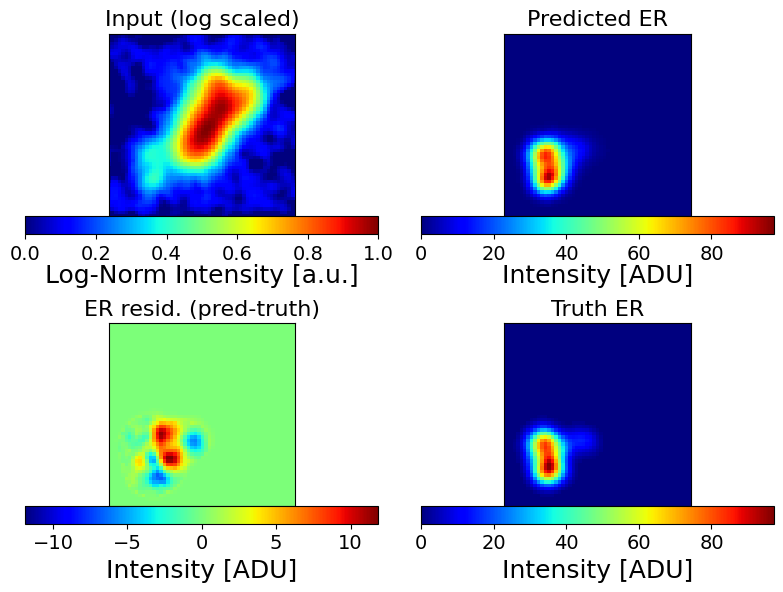

In [93]:
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)

key = 'hybrid'
species = 'hybrid'
visualize(dfs[species],
          models[key],
         datasets[key],
         idx = dfs[key].query('8 < ER_truth_energy < 9 & NR_camera_energy > 100').index.to_numpy()[1],
         mask = True,
         key=None)

Intensity percent diff (pred - truth) = -5.0, Epred = 5.917933750152588, Etruth = 6.2


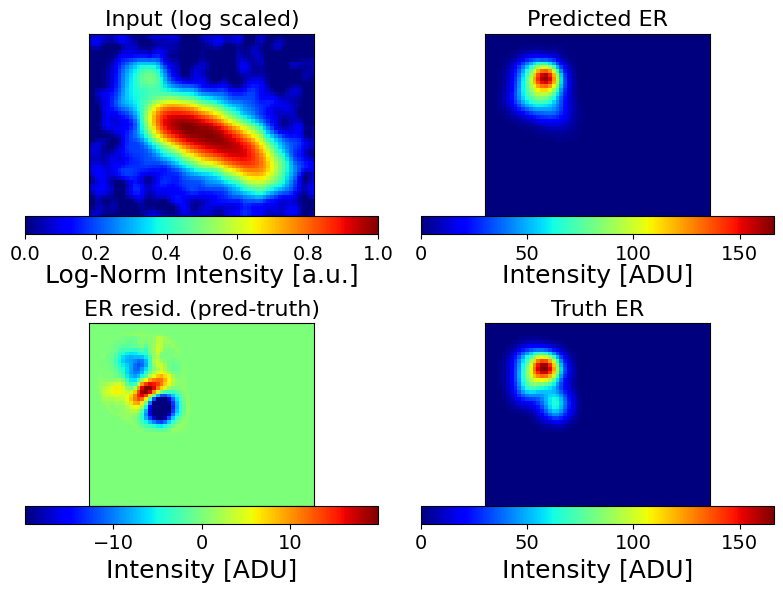

In [59]:
key = 'hybrid'
species = 'hybrid'
visualize(dfs[species],
          models[key],
         datasets[key],
         idx = dfs[key].query('5.5 < ER_truth_energy < 6.5 & NR_camera_energy > 100').index.to_numpy()[0],
         mask = True,
         key=None)

Intensity percent diff (pred - truth) = 11.0, Epred = 6.780323219299316, Etruth = 6.1


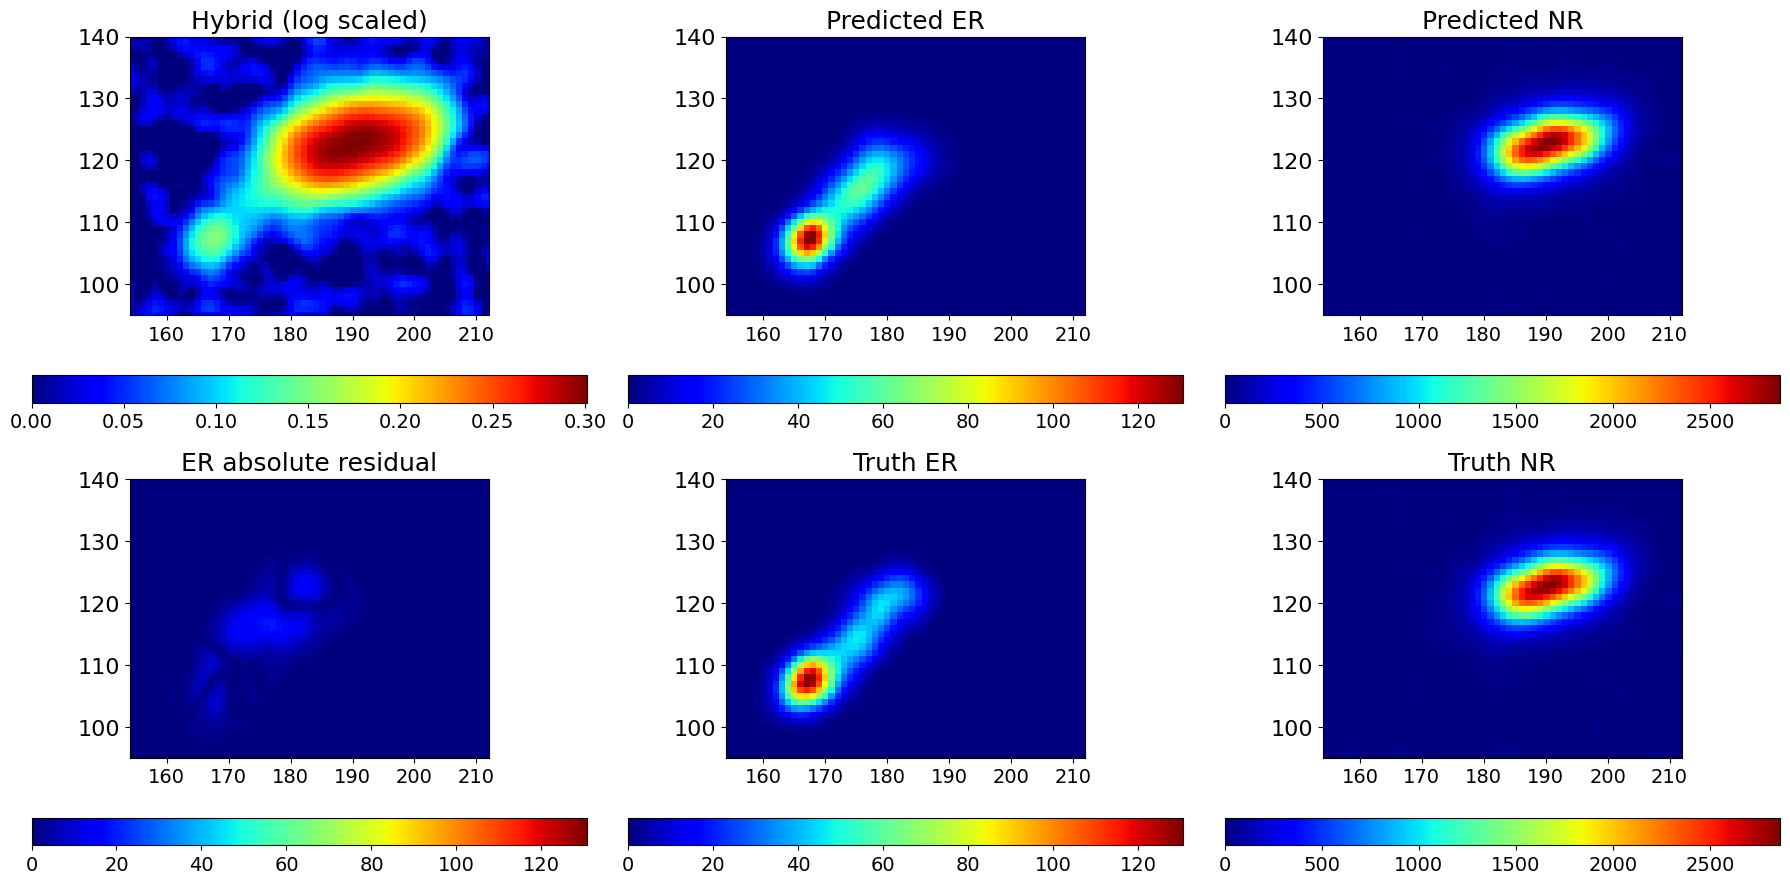

In [106]:
key = 'hybrid'
species = 'hybrid'
visualize(dfs[species],
          models[key],
         datasets[key],
         idx = dfs[key].query('5.5 < ER_truth_energy < 6.5 & 200 > NR_camera_energy > 100').index.to_numpy()[7],
         mask = True,
         plot_NR = True, #Set to show NR
         key=None)

/tmp/ipykernel_47812/4196835488.py:55: RuntimeWarning: divide by zero encountered in scalar divide
  np.round((I_hat_ER_raw[0,0].cpu().detach().numpy().sum()-t_ER_raw[0,0].cpu().detach().numpy().sum())/t_ER_raw[0,0].cpu().detach().numpy().sum()*100),


ER est. energy [keV]: 0.00034059565038996624


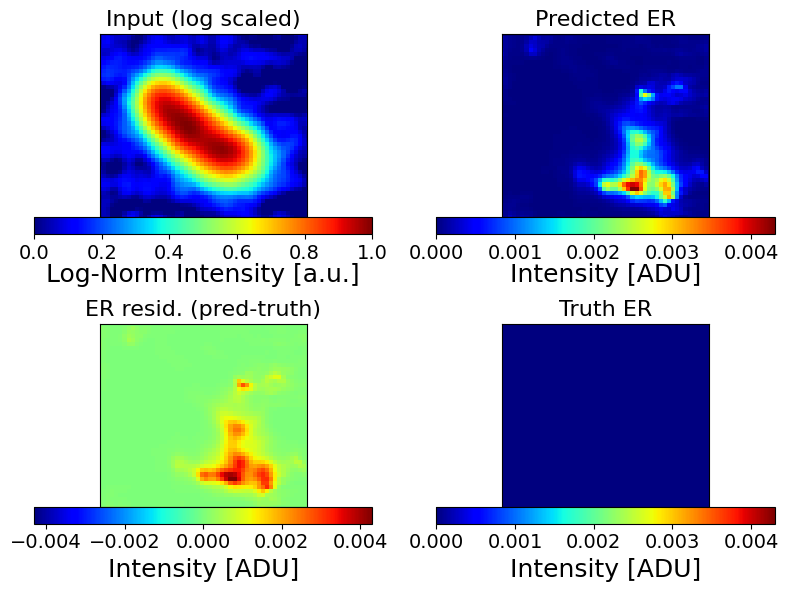

In [104]:
'''ER predicted intensity is effectively 0
For almost all truth NRs'''
key = 'NR'
species = 'NR'
visualize(dfs[species],
          models[key],
         datasets[key],
         idx = dfs[key].query('200 > NR_camera_energy > 100').index.to_numpy()[4],
         mask = True,
         key=None)

/tmp/ipykernel_47812/4196835488.py:55: RuntimeWarning: divide by zero encountered in scalar divide
  np.round((I_hat_ER_raw[0,0].cpu().detach().numpy().sum()-t_ER_raw[0,0].cpu().detach().numpy().sum())/t_ER_raw[0,0].cpu().detach().numpy().sum()*100),


ER est. energy [keV]: 0.00034059565038996624


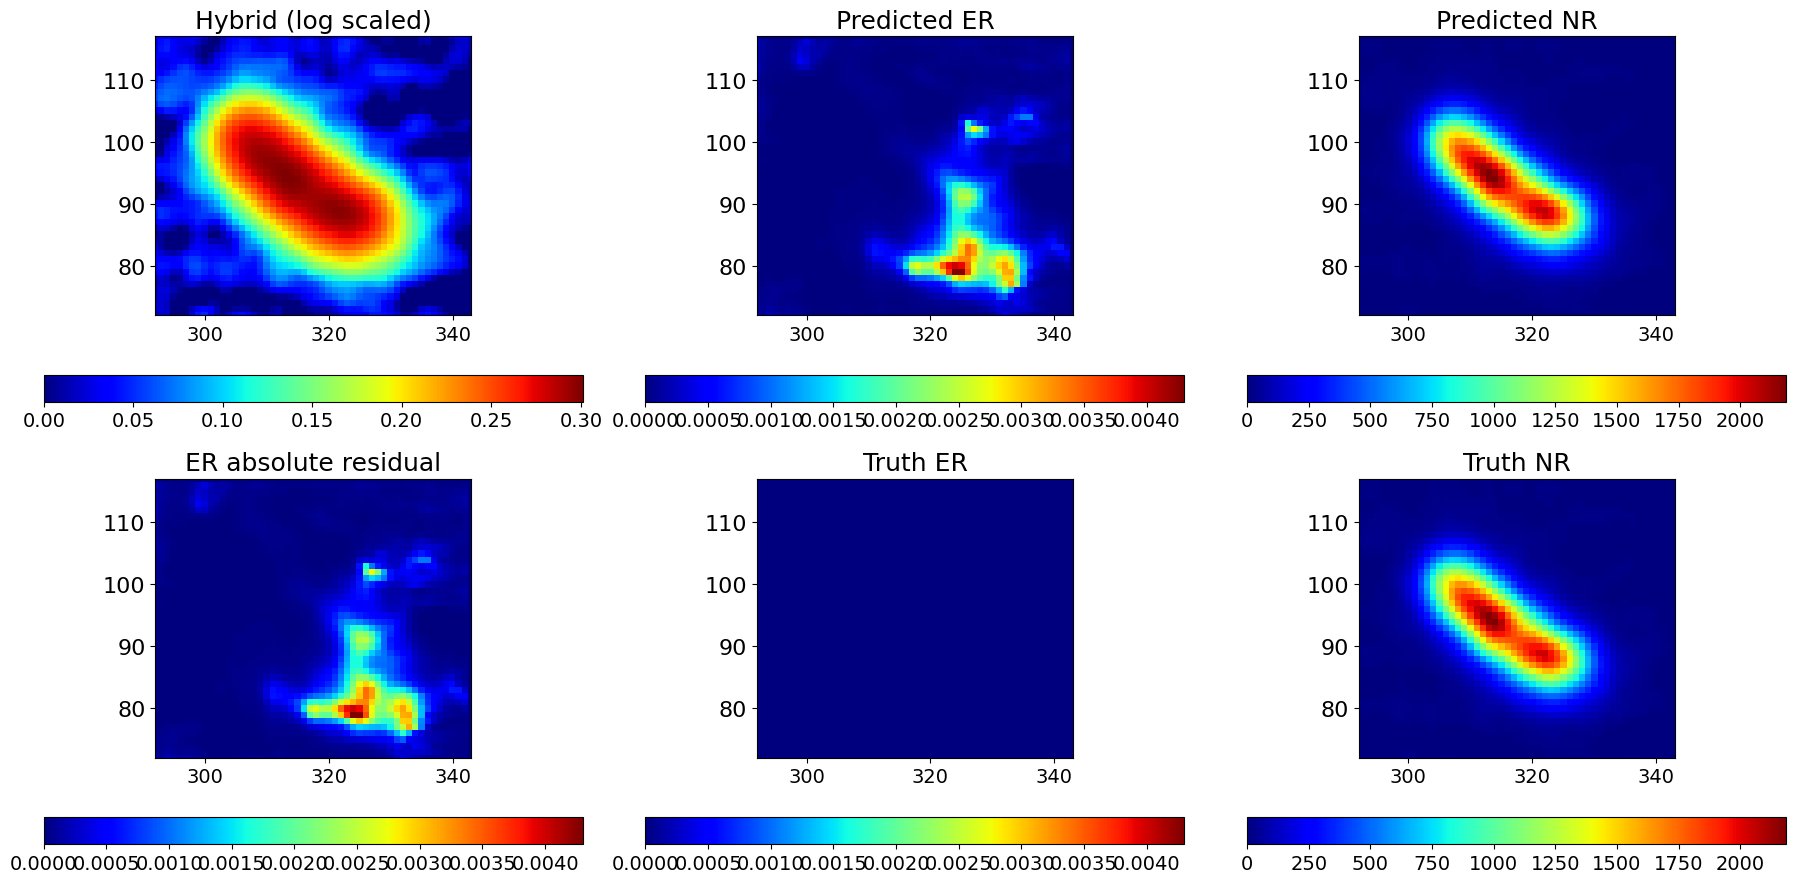

In [105]:
'''ER predicted intensity is effectively 0
For almost all truth NRs'''
key = 'NR'
species = 'NR'
visualize(dfs[species],
          models[key],
         datasets[key],
         idx = dfs[key].query('200 > NR_camera_energy > 100').index.to_numpy()[4],
         mask = True,
          plot_NR = True, #Set to show NR
         key=None)